 # 关于APP数据的探索

## 项目背景
在金融营销的过程中，了解客户的的基本属性、社会角色和兴趣爱好将有效提高推广营销的成功率，并且也有利于客户获得更好的服务体验。但是要想充分的了解客户，因为涉及隐私问题，部分数据的获取会有难度，虽然准确的信息我们无法获取，但是我们能做的是根据客户的某些行为来推测用户的信息。

一种用来推测用户信息的方法是根据用户手机上安装的应用来推测用户所具有的属性。例如，某用户手机上安装了“钉钉”，那么很有可能他是一名白领，由此我们可以向他推荐白领贷等理财产品。还有某些应用可以推测出用户的性别、地域、在哪些银行有业务等个人信息。

## 项目目标
建立每个应用对应的人群属性的标签体系。通过调研，我们主要需要解决以下几个问题：

* 现有手机应用商城中给出的应用类别划分，只能作为人群属性的参考，并没有明确的人群指向，我们需要列举一些关心的人群属性，作为应用的候选标签。比如，“上海人社”应用所属“本地应用”类别，我们需要给它标记为“常驻城市为上海”的标签。

* 我们可以通过人工来给应用打标签，但是应用的更迭速度迅速，为避免长期投入人力，我们需要实现给应用自动打标签，可行的方法是根据应用商城中的类别进行转换，根据应用的介绍文字利用规则或模型来自动打标签。

* 后续需要将这套打标签的方法，在含有人真实属性的实际数据中验证准确程度。

## 项目实施
这部分将介绍数据、构造的标签、数据的清洗与整理、已进行的探索。
### 数据
数据包括华为应用商城的应用介绍和类别的数据，以及Talking Data上统计的每个应用适用人群的特点。获取方式都为爬虫采集。
#### 华为应用商城数据

In [1]:
import pandas as pd
import numpy as np
huaWei=pd.read_pickle('E:/金融一账通/huaWei/huaweiapp_final_detail_3.pkl')
huaWei.columns=['appName','hwaWeiC1','hwaWeiC2','intro','label','package']
print(huaWei.shape[0])

50599


一共包含50599个应用的名字，所属的一级类别、二级类别、介绍等信息。

In [2]:
huaWei.head(2)

,appName,hwaWeiC1,hwaWeiC2,intro,label,package
0,秀来电,主题个性,铃声,秀来电是一款短视频铃声应用，将单调的系统来电提示音替换为丰富多彩的短视频铃声，让你秒变网红达...,"主题个性,铃声",com.hunting.matrix_showcaller
1,酷狗铃声,主题个性,铃声,同步酷狗百万曲库，海量铃声任你选！！！\n\n\n1、推荐铃声\n时下火热铃声推荐，抖音铃声...,"主题个性,酷狗,铃声,来电,短信",com.kugou.android.ringtone


#### Talking Data数据

In [3]:
talkingData=pd.read_csv("E:\pycharmWorkPlace\data\data1.txt")
print(talkingData.shape[0])

2328


一共包含2328个应用的名字、用户性别占比、年龄分布、兴趣爱好等信息。

In [4]:
talkingData.head(1)

,Unnamed: 0,age19Down,age19To25,age26To35,age36To45,age46To55,age55Up,appName,femalePer,malePer,...,preferMedia,preferNews,preferPhone,preferRead,preferShopping,preferSocial,preferTravel,preferWork,category,similarApp
0,0,0.031903,0.222365,0.543666,0.166094,0.03291,0.003062,微信,0.489636,0.510364,...,0.085721,0.07088,0.085561,0.062446,0.076307,0.067043,0.074916,0.067496,通讯社交--即时通讯,"QQ,触宝电话,多闪,米聊,WhatsApp Messenge,有信电话,子弹短信,飞信,S..."


### 构造的标签
|    属性    | 具体分类 |
| ---------- | --- |
| 性别 |  男、女、无法判断 |
| 年龄 |  老、中、青 |
| 婚育状况 |  未婚、孕妇或有婴儿、有小孩 |
| 活跃城市 |  北京、上海等城市或省份名 |
| 人群属性 |  白领、有车一族、旅游差旅、有租房需求、找工作需求者、爱美女性、学生、在考驾照、有贷款需求、有理财投资需求 |
| 已开户银行 | 各银行名 |
| 兴趣爱好 | 喜欢健身、喜欢电影、喜欢动漫、喜欢体育 |

### 数据探索
数据探索按照所用的数据分为两部分，第一部分是仅利用华为应用商城数据进行分析，第二部分是商城数据和talking Data数据结合起来的分析。其中，第二部分的分析效果不好，仅供参考。
#### 基于文本介绍的推断
如果只根据华为应用商城的数据，我们可以做的是根据文本介绍提取信息。
##### 用户所在城市
爬虫获取城市名字

In [5]:
import re
import requests
import json
from fake_useragent import UserAgent

In [8]:
ua = UserAgent(verify_ssl=False)
def get_json(url):
    headers = {'User-Agent': ua.random}
    r=requests.get(url,headers=headers)
    json_response=r.content.decode()
    json_dict=json.loads(json_response)
    return json_dict

In [9]:
cityDict=get_json('https://www.lagou.com/lbs/getAllCitySearchLabels.json')
cityList=[]
for city in cityDict['content']['data']['allCitySearchLabels'].values():
    for i in city:
        cityList.append(i['name'])

In [8]:
cityList#存储城市名的列表

['安庆',
 '澳门特别行政区',
 '鞍山',
 '安阳',
 '安顺',
 '安康',
 '阿克苏',
 '阿里地区',
 '北京',
 '保定',
 '北海',
 '包头',
 '蚌埠',
 '滨州',
 '宝鸡',
 '巴中',
 '保山',
 '亳州',
 '本溪',
 '巴音郭楞',
 '白城',
 '巴彦淖尔',
 '成都',
 '长沙',
 '重庆',
 '常州',
 '长春',
 '沧州',
 '赤峰',
 '潮州',
 '常德',
 '承德',
 '郴州',
 '滁州',
 '朝阳',
 '池州',
 '昌吉',
 '东莞',
 '大连',
 '德州',
 '东营',
 '德阳',
 '大庆',
 '大同',
 '达州',
 '大理',
 '定西',
 '德宏',
 '丹东',
 '迪庆',
 '儋州',
 '恩施',
 '鄂州',
 '鄂尔多斯',
 '佛山',
 '福州',
 '阜阳',
 '抚州',
 '抚顺',
 '阜新',
 '防城港',
 '广州',
 '贵阳',
 '桂林',
 '赣州',
 '广安',
 '广元',
 '甘孜藏族自治州',
 '贵港',
 '杭州',
 '合肥',
 '哈尔滨',
 '惠州',
 '海口',
 '呼和浩特',
 '湖州',
 '邯郸',
 '淮安',
 '海外',
 '怀化',
 '黄石',
 '衡水',
 '河源',
 '菏泽',
 '衡阳',
 '黄冈',
 '黄山',
 '淮北',
 '呼伦贝尔',
 '鹤壁',
 '淮南',
 '红河',
 '河池',
 '葫芦岛',
 '鹤岗',
 '哈密',
 '汉中',
 '贺州',
 '济南',
 '金华',
 '嘉兴',
 '江门',
 '济宁',
 '荆州',
 '揭阳',
 '吉林',
 '吉安',
 '晋中',
 '晋城',
 '九江',
 '锦州',
 '酒泉',
 '焦作',
 '荆门',
 '景德镇',
 '佳木斯',
 '金昌',
 '昆明',
 '开封',
 '克拉玛依',
 '喀什',
 '廊坊',
 '兰州',
 '临沂',
 '洛阳',
 '拉萨',
 '柳州',
 '聊城',
 '泸州',
 '龙岩',
 '吕梁',
 '乐山',
 '临汾',
 '丽水',
 '连云港',
 '丽江',
 '莱芜',
 '六盘水',
 '

以上网站只提供了城市的名字，没有省名，下面添加省名。

In [10]:
provList='北京，天津，上海，重庆，河北，山西，辽宁，吉林，黑龙江，江苏，浙江，安徽，福建，江西，山东，河南，湖北，湖南，广东，海南，四川，贵州，云南，陕西，甘肃，青海，台湾，内蒙古，广西，西藏，宁夏，新疆，香港'
provList=provList.split('，')
proCityList=cityList+provList#存储城市名和省名的列表

构造正则表达式

In [11]:
reStr='|'.join(proCityList)
proCityPt=re.compile(reStr)

匹配出现次数最多的地点名，后续会筛掉不能体现出常驻城市的结果，先粗略匹配。

In [12]:
import collections
def most_common(mycol, n=None):
    '''List the n most common elements and their counts from the most
    common to the least.  If n is None, then list all element counts.

    >>> Counter('abcdeabcdabcaba').most_common(3)
    [('a', 5), ('b', 4), ('c', 3)]
　　截取指定位数的值
    '''
    # Emulate Bag.sortedByCount from Smalltalk
    if n is None:
        return sorted(mycol.items(), reverse=True)
    return _heapq.nlargest(n, mycol.items())

def cityNum(mydf):
    try:
        return len(collections.Counter(proCityPt.findall(mydf["concat"])))
    except:
        return 0
    
def choosedNum(mydf):
    try:
        return most_common(collections.Counter(proCityPt.findall(mydf["concat"])))[0][1]
    except:
        return 0
def getCityOrProv(mydf):
    mydf['findCityNum']=None
    mydf['cityChoosedNum']=None
    mydf['CityOrProv']=None
    nameAndIntro=mydf['concat']
    for myindex,i in enumerate(nameAndIntro):
        try:
            mydf.loc[myindex,["CityOrProv"]]=most_common(collections.Counter(proCityPt.findall(i)))[0][0]
            mydf.loc[myindex,["findCityNum"]]=len(collections.Counter(proCityPt.findall(i)))
            mydf.loc[myindex,["cityChoosedNum"]]=most_common(collections.Counter(proCityPt.findall(i)))[0][1]
        except:
            pass

In [118]:
huaWei['concat']=huaWei['appName'].apply(lambda x: str(x))+huaWei['intro'].apply(lambda x: str(x))
huaWei["CityOrProv"]=None
huaWei["findCityNum"]=None
huaWei["cityChoosedNum"]=None

def cityName(mydf):
    try:
        return collections.Counter(proCityPt.findall(mydf["concat"])).most_common(1)[0][0]
    except:
        pass

def cityNum(mydf):
    try:
        return len(collections.Counter(proCityPt.findall(mydf["concat"])))
    except:
        return 0
    
def choosedNum(mydf):
    try:
        return most_common(collections.Counter(proCityPt.findall(mydf["concat"])))[0][1]
    except:
        return 0


In [119]:
huaWei["CityOrProv"]=huaWei.apply(lambda x: cityName(x),axis=1)
huaWei["findCityNum"]=huaWei.apply(lambda x: cityNum(x),axis=1)
huaWei["cityChoosedNum"]=huaWei.apply(lambda x: choosedNum(x),axis=1)

In [120]:
#筛选找出地名的数据子集
dtHaveCity = huaWei[huaWei["CityOrProv"].notna()]
len(dtHaveCity)

10569

In [121]:
dtHaveCity

,appName,hwaWeiC1,hwaWeiC2,intro,label,package,concat,findCityNum,cityChoosedNum,CityOrProv
14,微视,拍摄美化,短视频,让视频创作更简单，记录生活记录你 \n【美颜美妆美体，一键发现你的美】\n高清美颜，滤镜更丰...,"拍摄美化,视频拼接,特效,短视频,滤镜,特效相机,水印,配乐",com.tencent.weishi,微视让视频创作更简单，记录生活记录你 \n【美颜美妆美体，一键发现你的美】\n高清美颜，滤镜...,1,1,湖南
15,携程旅行,旅游住宿,旅游,携程旅行——携程在手，说走就走\n\n作为业界权威的在线旅行服务公司，携程旅行手机客户端提供...,"旅游住宿,自由行,机票,跟团游,酒店,景点门票,周末游,自驾游",ctrip.android.view,携程旅行携程旅行——携程在手，说走就走\n\n作为业界权威的在线旅行服务公司，携程旅行手机客...,1,2,海外
17,京东到家,美食,外卖,【新人礼】新用户首单最高立减15元，每天1元秒杀享不停。\n【品类全】生鲜，水果，蔬菜，零食...,"美食,外卖,购物,超市,生活服务,水果",com.jingdong.pdj,京东到家【新人礼】新用户首单最高立减15元，每天1元秒杀享不停。\n【品类全】生鲜，水果，蔬...,31,1,北京
25,盒马,美食,生鲜,截止9月底10月初，盒马在全国 15 个城市开了 87 家门店：上海、北京、深圳、广州、成都...,"美食,生鲜",com.wudaokou.hippo,盒马截止9月底10月初，盒马在全国 15 个城市开了 87 家门店：上海、北京、深圳、广州、...,15,1,上海
31,多点,美食,外卖,逛超市用多点，省时省钱超方便！多点App，50000000+用户的选择！\n \n【好货送到...,"美食,电商,外卖,购物,美容,支付,超市",com.wm.dmall,多点逛超市用多点，省时省钱超方便！多点App，50000000+用户的选择！\n \n【好货...,13,1,北京
35,UC浏览器,实用工具,浏览器,UC专注14年，成就全球最大第三方手机浏览器\n全球6亿人上网必备APP，群众的眼睛是雪亮的...,"实用工具,小说,浏览器,漫画,UC,头条",com.UCMobile,UC浏览器UC专注14年，成就全球最大第三方手机浏览器\n全球6亿人上网必备APP，群众的眼...,1,1,北京
36,平安好医生,运动健康,医疗,平安好医生拥有近千名全职医学团队，在线开设妇产科、儿科、内科、外科、皮肤科等22个科室，为用...,"运动健康,医生,计步器,医院,医疗",com.pingan.papd,平安好医生平安好医生拥有近千名全职医学团队，在线开设妇产科、儿科、内科、外科、皮肤科等22个...,4,1,北京
41,同程旅游,旅游住宿,旅游,新人狂领888元出游大礼包，即领即用；\n同程旅游，天天特价；爆款线路，周周上新。\n同程旅...,"旅游住宿,火车票,景点门票,机票,旅行,旅游,订票,酒店",com.tongcheng.android,同程旅游新人狂领888元出游大礼包，即领即用；\n同程旅游，天天特价；爆款线路，周周上新。\...,1,1,海外
49,360借条,金融理财,贷款,【特别声明】\n尊敬的用户：\n360借条属于360唯一授权信贷服务产品。360借条始终遵循...,"金融理财,贷款",com.qihoo.loan,360借条【特别声明】\n尊敬的用户：\n360借条属于360唯一授权信贷服务产品。360借...,1,1,福州
50,1药网,运动健康,医疗,1药网，专业的网上购药平台，获得国家食品、药品监督管理总局认证，其前身是：1号药店、壹药网。...,"运动健康,买药,用药,医疗,药店",com.yiwang,1药网1药网，专业的网上购药平台，获得国家食品、药品监督管理总局认证，其前身是：1号药店、壹...,3,1,北京


In [97]:
dtHaveCity.to_excel('./dthave.xlsx')

结果中“CityOrProv”为出现次数最多的城市名，“findCityNum”为找出的城市名的种类，“cityChoosedNum”为出现次数最多的城市出现的次数。

In [110]:
dtHaveCity.head()

,appName,hwaWeiC1,hwaWeiC2,intro,label,package,concat,findCityNum,cityChoosedNum,CityOrProv
0,秀来电,主题个性,铃声,秀来电是一款短视频铃声应用，将单调的系统来电提示音替换为丰富多彩的短视频铃声，让你秒变网红达...,"主题个性,铃声",com.hunting.matrix_showcaller,秀来电秀来电是一款短视频铃声应用，将单调的系统来电提示音替换为丰富多彩的短视频铃声，让你秒变...,0,0,[]
1,酷狗铃声,主题个性,铃声,同步酷狗百万曲库，海量铃声任你选！！！\n\n\n1、推荐铃声\n时下火热铃声推荐，抖音铃声...,"主题个性,酷狗,铃声,来电,短信",com.kugou.android.ringtone,酷狗铃声同步酷狗百万曲库，海量铃声任你选！！！\n\n\n1、推荐铃声\n时下火热铃声推荐，...,0,0,[]
2,铃声大全,主题个性,铃声,铃声大全、手机铃声、铃声宝库，就找多宝铃声，新潮好用的铃声大全，手机铃声助手。\n\n* 海...,"主题个性,铃声",com.treasure.ringtone,铃声大全铃声大全、手机铃声、铃声宝库，就找多宝铃声，新潮好用的铃声大全，手机铃声助手。\n\...,0,0,[]
3,壁纸多多,主题个性,壁纸,百万超高清无水印的主题锁屏和美图壁纸大全\n\n\n壁纸多多，百万高清美图主题桌面壁纸大全\...,"主题个性,主题,壁纸",com.shoujiduoduo.wallpaper,壁纸多多百万超高清无水印的主题锁屏和美图壁纸大全\n\n\n壁纸多多，百万高清美图主题桌面壁...,0,0,[]
4,装扮少女,主题个性,壁纸,♥♥ 装扮少女，治愈九亿少女心 ♥♥\n\n为每一个女孩子们独家定制的专属换装\n满足你的所...,"主题个性,壁纸",com.cameras.prettygirls,装扮少女♥♥ 装扮少女，治愈九亿少女心 ♥♥\n\n为每一个女孩子们独家定制的专属换装\n满...,0,0,[]


共匹配出10569个应用含有城市名,发现有很大一部分是匹配错误的。

In [18]:
#标注了1709条数据
dtTest=pd.read_excel('C:/Users/zc960410/huaWeiApp/bank/needNote.xlsx')
dtTest=dtTest[:1709]
dtTest

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,appname,c1,c2,detailappintrocard,detaillabelcard,bank,loanDemand,financialDemand,equityFund,haveCar,learnCar,momWithBaby,female,CityOrProv,TrueProv
0,16382,16382,16622,红网论坛,社交通讯,社区,红网论坛是湖南省官方网络互动平台。注册用户、在线人数与日发帖量均保持前列，也已成为湖南人的网...,"社交通讯,社区",NaN,0,0,0,0,0,0,0,长沙,湖南
1,29201,29201,32068,球鞋发售日历,实用工具,工具,球鞋发售日历是一个围绕球鞋、聚集Sneaker的开放平台，你可以在里面看到最新、最潮的球鞋发...,"实用工具,工具",NaN,0,0,0,0,0,0,0,海外,NaN
2,45874,45874,70753,南钢产销大数据平台,商务,效率,南钢产销大数据平台是上海钢之家电子商务股份有限公司（www.steelhome.cn）为南京...,"商务,效率",NaN,0,0,0,0,0,0,0,南京,南京
3,9996,9996,10236,证件照,拍摄美化,图像美化,证件照随拍，您的手机照相馆！证件照随拍是由无锡向日文化传媒有限公司开发的一款手机制作证件照片...,"拍摄美化,图像美化",NaN,0,0,0,0,0,0,0,无锡,NaN
4,14312,14312,14552,南太湖,社交通讯,社区,南太湖提供生活资讯类服务信息网站。南太湖通过传达最及时的地方信息、反映最生动的民生百态、表达...,"社交通讯,资讯,家居,房产,新闻,装修,社区",NaN,0,0,0,0,0,0,0,湖州,湖州
5,38190,38190,58474,银川发布,新闻阅读,新闻,“银川发布”是银川市委外宣办、市政府新闻办授权银川新闻网独家运营的网络平台，是您了解银川、读...,"新闻阅读,报纸,新闻,资讯,实事",NaN,0,0,0,0,0,0,0,银川,银川
6,39779,39779,61155,邢台信息港,便捷生活,本地生活,邢台信息港APP是邢台信息港网站www.0319xt.cn精心打造的为邢台人民提供吃、喝、玩...,"便捷生活,本地生活",NaN,0,0,0,0,0,0,0,邢台,邢台
7,23831,23831,24739,彩虹特惠,购物比价,优惠,概述：\r\n彩虹特惠是合肥爱惠淘网络传媒有限公司旗下的一款手机购物软件APP，专注于淘宝京...,"购物比价,优惠",NaN,0,0,0,0,0,0,0,海外,NaN
8,44124,44124,67873,CEO户外联盟,商务,效率,CEO户外联盟，由深圳前海同行者咨询有限公司开发。供合伙人使用，旨在联合国内众多CEO平台，...,"商务,效率",NaN,0,0,0,0,0,0,0,深圳,NaN
9,16417,16417,16657,阅达书城,购物比价,商城,“阅达书城”是湖南省新华书店集团旗下线上购书APP，\n“阅达书城”依托遍布全省的百家门店，...,"购物比价,商城",NaN,0,0,0,0,0,0,0,湖南,湖南


CityOrProv为上一个方法得到的最佳匹配，TrueProv为人工标注，相同的为为对的，不同的为错的，构造一个判断对的还是错的的模型。

In [22]:
#mask，预测对为1
dtTest["mask"]=0
dtTest.loc[(dtTest["CityOrProv"]==dtTest["TrueProv"]),"mask"]=1

从已匹配出城市的10558个app中标注了1709条数据，匹配正确的记为1，错误的记为0。模型选取了四种特征：

- 特征1：app名和介绍合并后tfidfVector
- 特征2：出现的城市的个数
- 特征3：众数城市出现的次数
- 特征4：众数城市和app名的相似程度的j-wScore（结合了公共字符数和出现顺序并且字符前面会有更高的权重）

先计算特征4.

In [31]:
import jellyfish
#jellyfish.jaro_winkler(dtTest["appname"].values[0],dtTest["CityOrProv"].values[0])
def getJwScore(df):
    #print(df)
    return jellyfish.jaro_winkler(df["appname"],df["CityOrProv"])

In [34]:
dtTest["jwScore"]=0
dtTest["jwScore"]=dtTest.apply(lambda x: getJwScore(x),axis=1)

计算特征2和特征3

In [83]:
dtTest['concat']=dtTest['appname'].apply(lambda x: str(x))+dtTest['detailappintrocard'].apply(lambda x: str(x))
dtTest["findCityNum"]=None
dtTest["cityChoosedNum"]=None
def cityNum(mydf):
    try:
        return len(collections.Counter(proCityPt.findall(mydf["concat"])))
    except:
        return 0
    
def choosedNum(mydf):
    try:
        return most_common(collections.Counter(proCityPt.findall(mydf["concat"])))[0][1]
    except:
        return 0

In [84]:
dtTest["findCityNum"]=dtTest.apply(lambda x: cityNum(x),axis=1)
dtTest["cityChoosedNum"]=dtTest.apply(lambda x: choosedNum(x),axis=1)

In [85]:
dtTest

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,appname,c1,c2,detailappintrocard,detaillabelcard,bank,loanDemand,...,learnCar,momWithBaby,female,CityOrProv,TrueProv,mask,jwScore,findCityNum,cityChoosedNum,concat
0,16382,16382,16622,红网论坛,社交通讯,社区,红网论坛是湖南省官方网络互动平台。注册用户、在线人数与日发帖量均保持前列，也已成为湖南人的网...,"社交通讯,社区",NaN,0,...,0,0,0,长沙,湖南,0,0.000000,14,1,红网论坛红网论坛是湖南省官方网络互动平台。注册用户、在线人数与日发帖量均保持前列，也已成为湖...
1,29201,29201,32068,球鞋发售日历,实用工具,工具,球鞋发售日历是一个围绕球鞋、聚集Sneaker的开放平台，你可以在里面看到最新、最潮的球鞋发...,"实用工具,工具",NaN,0,...,0,0,0,海外,NaN,0,0.000000,1,1,球鞋发售日历球鞋发售日历是一个围绕球鞋、聚集Sneaker的开放平台，你可以在里面看到最新、...
2,45874,45874,70753,南钢产销大数据平台,商务,效率,南钢产销大数据平台是上海钢之家电子商务股份有限公司（www.steelhome.cn）为南京...,"商务,效率",NaN,0,...,0,0,0,南京,南京,1,0.537037,2,1,南钢产销大数据平台南钢产销大数据平台是上海钢之家电子商务股份有限公司（www.steelho...
3,9996,9996,10236,证件照,拍摄美化,图像美化,证件照随拍，您的手机照相馆！证件照随拍是由无锡向日文化传媒有限公司开发的一款手机制作证件照片...,"拍摄美化,图像美化",NaN,0,...,0,0,0,无锡,NaN,0,0.000000,1,1,证件照证件照随拍，您的手机照相馆！证件照随拍是由无锡向日文化传媒有限公司开发的一款手机制作证...
4,14312,14312,14552,南太湖,社交通讯,社区,南太湖提供生活资讯类服务信息网站。南太湖通过传达最及时的地方信息、反映最生动的民生百态、表达...,"社交通讯,资讯,家居,房产,新闻,装修,社区",NaN,0,...,0,0,0,湖州,湖州,1,0.000000,2,1,南太湖南太湖提供生活资讯类服务信息网站。南太湖通过传达最及时的地方信息、反映最生动的民生百态...
5,38190,38190,58474,银川发布,新闻阅读,新闻,“银川发布”是银川市委外宣办、市政府新闻办授权银川新闻网独家运营的网络平台，是您了解银川、读...,"新闻阅读,报纸,新闻,资讯,实事",NaN,0,...,0,0,0,银川,银川,1,0.833333,1,10,银川发布“银川发布”是银川市委外宣办、市政府新闻办授权银川新闻网独家运营的网络平台，是您了解...
6,39779,39779,61155,邢台信息港,便捷生活,本地生活,邢台信息港APP是邢台信息港网站www.0319xt.cn精心打造的为邢台人民提供吃、喝、玩...,"便捷生活,本地生活",NaN,0,...,0,0,0,邢台,邢台,1,0.800000,1,6,邢台信息港邢台信息港APP是邢台信息港网站www.0319xt.cn精心打造的为邢台人民提供...
7,23831,23831,24739,彩虹特惠,购物比价,优惠,概述：\r\n彩虹特惠是合肥爱惠淘网络传媒有限公司旗下的一款手机购物软件APP，专注于淘宝京...,"购物比价,优惠",NaN,0,...,0,0,0,海外,NaN,0,0.000000,2,1,彩虹特惠概述：\r\n彩虹特惠是合肥爱惠淘网络传媒有限公司旗下的一款手机购物软件APP，专注...
8,44124,44124,67873,CEO户外联盟,商务,效率,CEO户外联盟，由深圳前海同行者咨询有限公司开发。供合伙人使用，旨在联合国内众多CEO平台，...,"商务,效率",NaN,0,...,0,0,0,深圳,NaN,0,0.000000,1,1,CEO户外联盟CEO户外联盟，由深圳前海同行者咨询有限公司开发。供合伙人使用，旨在联合国内众...
9,16417,16417,16657,阅达书城,购物比价,商城,“阅达书城”是湖南省新华书店集团旗下线上购书APP，\n“阅达书城”依托遍布全省的百家门店，...,"购物比价,商城",NaN,0,...,0,0,0,湖南,湖南,1,0.000000,1,1,阅达书城“阅达书城”是湖南省新华书店集团旗下线上购书APP，\n“阅达书城”依托遍布全省的百...


保存数据

In [86]:
dtTest.to_excel('./dtTest.xlsx')

数据可视化，寻找关系。

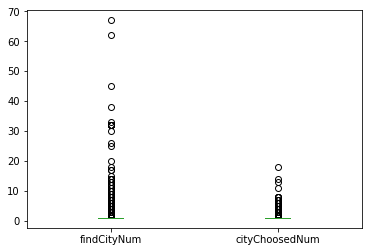

In [87]:
import matplotlib.pyplot as plt
plt.ion()
dtTest[dtTest["mask"]==0][["findCityNum","cityChoosedNum"]].plot.box()

上图是对于不应该标记城市标签的app中，含有的城市种类数（findCityNum）较多，而为众数的app出现的次数(cityChoosedNum)不多。

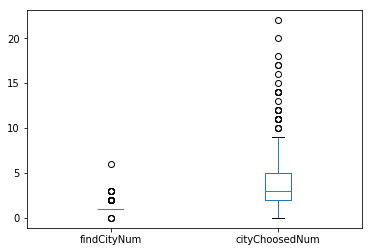

In [88]:
import matplotlib.pyplot as plt
plt.ion()
dtTest[dtTest["mask"]==1][["findCityNum","cityChoosedNum"]].plot.box()

而对于本地app，在介绍中出现的城市数量虽然不多，但是某一城市名出现过很多次。

下面用特征2、3、4，没有用tfidf，构造logistic回归，效果和之前算过的加入tfidf的模型几乎一样，所以这里不再加入特征1。

In [90]:
X1=np.array(dtTest.loc[:,["jwScore","findCityNum","cityChoosedNum"]])
y=dtTest["mask"]
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X1,y, test_size=0.2) 
logistic_model = LogisticRegression() 
logistic_model.fit(train_X, train_y) 
logistic_model.score(test_X, test_y)

0.8450292397660819

In [91]:
y_pred = logistic_model.predict(test_X)
print(classification_report(test_y, y_pred))

             precision    recall  f1-score   support

          0       0.85      0.95      0.90       241
          1       0.84      0.58      0.69       101

avg / total       0.84      0.85      0.84       342



XGBoost在我自己的电脑上（win）上不好安装，链接是在linux上之前做的，可以看下结果。

[XGBoost model](file:///C:/Users/zc960410/Downloads/%E8%AF%86%E5%88%AB%E5%9C%B0%E5%90%8D%E6%AD%A3%E7%A1%AE%E8%BF%98%E6%98%AF%E9%94%99%E8%AF%AFXGB.html)

在所有标记过城市名的数据上预测，我们看一下效果。

In [93]:
def getJwScore(df):
    #print(df)
    return jellyfish.jaro_winkler(df["appName"],df["CityOrProv"])

In [122]:
dtHaveCity["jwScore"]=0
dtHaveCity["jwScore"]=dtHaveCity.apply(lambda x: getJwScore(x),axis=1)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [126]:
X1UnTag=np.array(dtHaveCity.loc[:,["jwScore","findCityNum","cityChoosedNum"]])
dtHaveCity["CityTag"]=None
dtHaveCity["CityTag"]=logistic_model.predict(X1UnTag)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [127]:
dtHaveCity[dtHaveCity["CityTag"]==1]

,appName,hwaWeiC1,hwaWeiC2,intro,label,package,concat,findCityNum,cityChoosedNum,CityOrProv,jwScore,bankTag,CityTag
345,亚马逊购物,购物比价,海淘,【关于亚马逊购物】\n全球挚爱的跨境电商购物平台，同步全球品质生活，海外正品直邮， 尽在亚马...,"购物比价,购物,海淘,电商,亚马逊",cn.amazon.mShop.android,亚马逊购物【关于亚马逊购物】\n全球挚爱的跨境电商购物平台，同步全球品质生活，海外正品直邮，...,1,6,海外,0.000000,1,1
390,掌上生活,便捷生活,本地生活,掌上生活v7.2，品质生活，没那么复杂。\n掌上生活App由招商银行信用卡官方出品，是一款以...,"便捷生活,本地生活,还款,生活服务,商城,购物",com.cmbchina.ccd.pluto.cmbActivity,掌上生活掌上生活v7.2，品质生活，没那么复杂。\n掌上生活App由招商银行信用卡官方出品，...,1,2,上海,0.583333,1,1
419,上海交警,汽车,违章查询,欢迎使用上海市公安局交通警察总队官方发布的“上海交警”APP。主要功能： \n1.交通违法行...,"汽车,违章查询",com.mobi.shtp,上海交警欢迎使用上海市公安局交通警察总队官方发布的“上海交警”APP。主要功能： \n1.交...,1,3,上海,0.833333,1,1
476,Metro大都会,出行导航,公交地铁,Metro大都会是上海地铁推出的 “地铁+”互联网服务平台，让乘车更简单，出行更高效。\n乘...,"出行导航,公交地铁",com.app.shanghai.metro,Metro大都会Metro大都会是上海地铁推出的 “地铁+”互联网服务平台，让乘车更简单，出...,1,5,上海,0.000000,1,1
505,亿通行,出行导航,交通票务,易通行App，提供北京地铁在线购票服务，是上班族和来京差旅人士必备的北京地铁出行神器。\n有...,"出行导航,交通票务",enfc.metro,亿通行易通行App，提供北京地铁在线购票服务，是上班族和来京差旅人士必备的北京地铁出行神器。...,1,9,北京,0.000000,1,1
580,北京交警,汽车,违章查询,欢迎您使用北京交管局和北京中车宝联科技有限责任公司推出的“北京交警”手机客户端快速处理机动车...,"汽车,违章查询",com.zcbl.bjjj_driving,北京交警欢迎您使用北京交管局和北京中车宝联科技有限责任公司推出的“北京交警”手机客户端快速处...,1,4,北京,0.833333,1,1
605,广东移动,实用工具,Wi-Fi,广东移动手机营业厅是中国移动广东有限公司官方专为中国移动广东用户打造的手机客户端。\n无论您...,"实用工具,客服,流量,Wi-Fi,营业厅,套餐,移动,话费",com.kingpoint.gmcchh,广东移动广东移动手机营业厅是中国移动广东有限公司官方专为中国移动广东用户打造的手机客户端。\...,1,5,广东,0.833333,1,1
661,天津地铁,出行导航,公交地铁,天津地铁官方APP正式上线啦。有了这款地铁出行APP，您无需先购票再乘车，登录天津地铁APP...,"出行导航,公交地铁",com.bwton.tjmetro,天津地铁天津地铁官方APP正式上线啦。有了这款地铁出行APP，您无需先购票再乘车，登录天津地...,1,3,天津,0.833333,1,1
722,长沙地铁,出行导航,公交地铁,长沙市轨道交通互联网售检票系统平台是长沙轨道公司自建自运营的、基于传统售检票系统功能基础上增...,"出行导航,公交地铁",com.chinasofti.shanghaihuateng.metroapp,长沙地铁长沙市轨道交通互联网售检票系统平台是长沙轨道公司自建自运营的、基于传统售检票系统功能...,1,4,长沙,0.833333,1,1
754,上海移动和你,便捷生活,本地生活,通过“上海移动和你”APP充值享9.98折，“周三充值专享日”享充值加赠5%；\n动动手指签...,"便捷生活,本地生活",com.sh.cm.shydhn,上海移动和你通过“上海移动和你”APP充值享9.98折，“周三充值专享日”享充值加赠5%；\...,1,2,上海,0.777778,1,1


上面显示的是打上城市标记的app，结果比较准。

In [128]:
dtHaveCity.to_excel("./dtHaveCity.xlsx")

##### 提取相关银行名称
近些年来，各家银行纷纷开发手机银行等软件来方便客户办理银行业务，所以我们可以从软件看出用户在哪些银行有业务。如果该客户在这家银行里已经开设账户，我们可以向他推荐这个银行的理财产品。

In [2]:
import fool
import pandas as pd
import numpy as np
import jieba
import re

D:\Anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


为了把银行的名字能够分词时分出来，这里导入用户词表“bank.txt”，其中包含了搜集到的尽可能多的银行名字。

In [3]:
jieba.load_userdict('C:/Users/zc960410/huaWeiApp/bank/bank.txt')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\zc960410\AppData\Local\Temp\jieba.cache
Loading model cost 1.432 seconds.
Prefix dict has been built succesfully.


对于常见的银行，会用简称，比如说“工行”也代表“中国工商银行”，对于后续匹配出的结果，我们将简称对应到全称。所以定义以下字典。

In [4]:
bankTwoName={'工行':'中国工商银行','农行':'中国农业银行','建行':'中国建设银行','交行':'交通银行'}

正则匹配介绍中出现的银行名。

In [20]:
def findBank(mydf):
    #print(mydf["appname"])
    concat=str(mydf["appName"])+str(mydf["intro"])
    jiebaResult=jieba.lcut(concat)
    bankpt=re.compile(r'.+银行$|.+农信|.+信用社|[工农建交]行')
    findBank=[]
    for word in jiebaResult:
        if bankpt.findall(word):
            findBank.append(bankpt.findall(word))
    if len(findBank)>0:
        if findBank[0][0] in bankTwoName:
            findBank[0]=bankTwoName[findBank[0][0]]
        return findBank[0][0]

In [21]:
huaWei["bank"]=huaWei.apply(lambda x: findBank(x),axis=1)

用以上匹配方式，匹配到的结果展示如下。

In [22]:
huaWei[huaWei["bank"].notnull()]

,appName,hwaWeiC1,hwaWeiC2,intro,label,package,bank
165,榕树贷款,金融理财,贷款,榕树贷款，创新的智慧金融服务平台。0-30万额度随心选，1分钟快速到账。急用钱找榕树，保证有...,"金融理财,贷款",com.shuqu.banyan,招商银行
168,工银e生活,美食,餐饮,工银e生活是中国工商银行信用卡官方客户端。全新升级的2.0版本是集生活、消费和金融服务于一体...,"美食,商城,餐饮,购物,娱乐,优惠,导航,支付",com.icbc.elife,中国工商银行
170,企业信用信息查询,商务,办公软件,企查查是一款企业信用信息查询工具，帮助用户快速了解企业状况，提升办公效率。\n\n企查查拥有...,"商务,办公软件",com.greatid.business,中国银行
179,51信用卡管家,金融理财,贷款,信好有你，51信用卡港股上市公司。 \n－贷款产品好：额度高，下款快，利率低。 \n－信用卡...,"金融理财,贷款,金融,购物,信用卡,投资,账单,借贷",com.zhangdan.app,建设银行
239,企业工商征信查询,商务,效率,企查查是一款企业信用信息查询工具，帮助用户快速了解企业状况。\n\n企查查拥有全国1.5亿家...,"商务,效率",com.android.qichacha,中国银行
317,宜人财富,金融理财,理财,【宜人财富简介】\n宜人财富是美国纽交所上市公司宜人贷（NYSE: YRD）旗下的在线财富管...,"金融理财,理财",com.creditwealth.client,广发银行
331,闪银,金融理财,理财,一、产品介绍：\n【手机贷款额度高】500元起借，额度最高5万；\n【审核放款速度快】评估仅...,"金融理财,金融,分期,钱包,信用评估,理财",com.syqy.wecash,非银行
379,铁路12306,出行导航,交通票务,铁路12306是中国铁路总公司官方出品的手机购票客户端，用户可以在手机上预订车票、在线支付、...,"出行导航,票价,订票,列车时刻表,火车票,货运,交通票务",com.MobileTicket,工商银行
390,掌上生活,便捷生活,本地生活,掌上生活v7.2，品质生活，没那么复杂。\n掌上生活App由招商银行信用卡官方出品，是一款以...,"便捷生活,本地生活,还款,生活服务,商城,购物",com.cmbchina.ccd.pluto.cmbActivity,招商银行
398,中国建设银行,金融理财,银行,"建设银行专为手机银行客户打造的移动金融服务平台,在具备转账汇款、缴费支付、投资理财、账户管理...","金融理财,汇款,缴费,银行,金融",com.chinamworld.main,中国建设银行


In [24]:
print(huaWei[huaWei["hwaWeiC1"]=='金融理财'].shape[0])
print(huaWei[huaWei["hwaWeiC1"]=='金融理财'][huaWei["bank"].notnull()].shape[0])

4879
959


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [36]:
needTag=huaWei[huaWei["hwaWeiC1"]=='金融理财'][huaWei["bank"].isnull()]

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


我们看到有4879个标签为“金融理财”的应用，其中有959个被打上了银行标签。但是不可否认的是，对于用户字典里没有收录的银行名字，我们可能漏掉了。下面用命名实体识别出公司名，再进行匹配。

In [38]:
bankpt= re.compile(r'.+银行$|.+农信|.+信用社|[工农建交]行')
for index,i in needTag.iterrows():
    company=[]
    text=i["intro"]
    words,ners=fool.analysis(text)
    for nerList in ners:
        for ner in nerList:
            nerType=ner[2]
            nerName=ner[3]
            if nerType=='company':
                company.append(nerName)
    #print(company)
    
    findBank=[]
    for word in company:
        if bankpt.findall(word):
            findBank.append(bankpt.findall(word))
            #print(findBank)
    if len(findBank)>0:
        #print(str(findBank[0]))
        if findBank[0][0] in bankTwoName:
            findBank[0]=bankTwoName[findBank[0][0]]
        i["bank"]=findBank[0][0]
        huaWei.loc[index,"bank"]=i["bank"]
        if (len(findBank[0][0])>4) & (findBank[0][0][-4:]=="手机银行"):
            i["bank"]=findBank[0][0][:-4]
            huaWei.loc[index,"bank"]=i["bank"]
        #dt.loc[(dt['appname']==i),'bank']=findBank[0] 

In [39]:
needTag[needTag["bank"].notnull()]

,appName,hwaWeiC1,hwaWeiC2,intro,label,package,bank
3089,陕西信合,金融理财,银行,陕西信合手机银行进行全面的改版、升级，为个人客户提供全方位、多功能的移动金融服务。无论您是否...,"金融理财,银行",com.sxnxs.mbank,陕西信合
4389,信用钱包,金融理财,理财,信用钱包：4000万用户的选择 助力每一个梦想成长\n【产品特色】\n◇ 借款快速：在线申请...,"金融理财,理财,钱包,借贷,信贷,信用,贷款",com.financial.quantgroup,网商银行
5931,小赢理财,金融理财,理财,1.实缴注册资本增至5亿元\n2.中国互联网金融协会会员单位\n3.新手注册送688元红包，...,"金融理财,理财",com.yingzt.invest,百信银行
6732,中和金服,金融理财,贷款,应用介绍：\n上门贷款、极速贷款，满足不同贷款需求\n按期还款、提前还款，支持各类还款方式\...,"金融理财,贷款",com.cfpamf.zhjfapp,中和农信
8859,北部湾手机银行,金融理财,银行,主要特性：\n一、 更安全\n采用人脸生物识别、第三代KEY和短信验证码作为认证工具，不仅防...,"金融理财,银行",com.yitong.bbw.mbank.android,广西北部湾银行
12667,小雨伞保险,金融理财,理财,【我们是谁】 互联网保险特卖平台，基于互联网大数据，联合保险公司，打造高性价比保险产品，服务...,"金融理财,理财",com.xiaoyusan.android,亚洲银行
13560,邢台银行,金融理财,银行,转账汇款、存钱理财要到银行排队？话费充值、生活缴费只能去营业厅？吃喝玩乐去哪里还要苦苦思索？...,"金融理财,银行",com.seaway.bank.xingtai,邢台银行
22144,宁波通商,金融理财,银行,“宁波通商”手机银行APP（1.0.0）于2016年10月18日隆重上线啦！“宁波通商”手机...,"金融理财,银行",com.ncbank,宁波通商银行
23915,华润直销银行,金融理财,银行,华润直销银行android版专为您打造一流的在线金融服务，全程在线开户，独创金融日历功能，并...,"金融理财,金融,转账,银行",cn.com.hrcrb.mobile.directbank,华润直销银行
24462,阳光村镇银行,金融理财,银行,阳光村镇银行移动银行是面向大众客户提供一款集金融服务、智能增值服务、生活服务于一体的移动服务...,"金融理财,银行",com.dhcc.app,阳光村镇银行移动银行


In [40]:
huaWei[huaWei["bank"].notnull()].shape[0]

(1188, 7)

In [41]:
1188-959

229

命名实体识别在原来匹配出的959个的基础上又打上了229个标签。
#####  其他
有一些人群类别，初步认为可以利用现有的华为商城分类直接得到。
* 二级类别为“贷款”可对应“有贷款需求”的人群属性
* 二级标签为“理财”可对应“有理财需求”的人群属性
* 二级标签为“汽车资讯类”，“养车”，“违章查询”可对应“有车一族”
* 二级标签为“母婴”可对应“有婴儿”，“女性”

#### 基于Talking Data数据的分析
结合Talking Data的数据我们可以探索应用和人群属性的关系，而不是根据日常经验来推测使用人的特点。

这里用到的数据为华为应用商城数据与Talking Data数据进行匹配，得到的1551个应用的数据。可以利用其探索的主要是年龄特点和性别。
#####  年龄

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
dt=pd.read_excel('E:金融一账通/huaWei/resultJellyFishAfterFilter.xlsx')
age=dt.iloc[:,2:8]
age.idxmax(axis=1).value_counts()

age26To35    1550
age19To25       1
dtype: int64

在1551个app中只有一个app的使用最多的用户不是26到35岁，我们可以看看哪个应用。

In [44]:
dt[pd.DataFrame(age.idxmax(axis=1))[0]=="age19To25"]

,Unnamed: 0,Unnamed: 0.1,age19Down,age19To25,age26To35,age36To45,age46To55,age55Up,appName,category,...,preferMakeUp,preferMedia,preferNews,preferPhone,preferRead,preferShopping,preferSocial,preferTravel,preferWork,similarApp
1534,2506,1421,0.0,0.423077,0.384615,0.153846,0.038462,0.0,小美快购,网络购物--生鲜电商,...,0.002786,0.077994,0.069638,0.077994,0.064067,0.077994,0.05571,0.072423,0.069638,"盒马,每日优鲜,美菜商城,本来生活,百果园,天天果园,妙生活,两鲜,U掌柜,易果生鲜"


我们可以看看年龄分布的平均值是怎样的

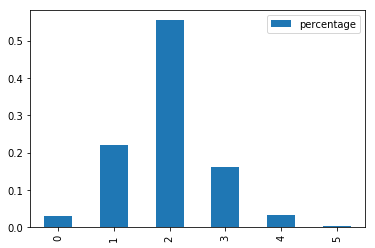

In [45]:
meanList=age.mean()
per=pd.DataFrame({"ageStage":meanList.index,"percentage":meanList.values})
plt.ion()
pd.DataFrame({"ageStage":meanList.index,"percentage":meanList.values}).plot.bar()

26~35岁的app用户最多，其次是19~25岁的用户，呈现轻微的右偏分布

我们可以把各个应用的年龄比例数据减去分布平均值，这样我们可以更容易看出与平均值相比，应用的年龄分布的轻微差异。但是这种差异只是一个相对值，绝对值仍然是26~35用户最多（1551个APP中有1550个）。产生这一数据的原因可能是Talking Data的数据准确性，也有可能是所用的数据太少，还没有收录一些被老年群体、学生群体使用的应用。

但是为了进行初步的探索，继续做了相对值（年龄分布减去均值）数据的探索。

In [46]:
dt1=pd.DataFrame((age-age.mean()))
dt1.head()

,age19Down,age19To25,age26To35,age36To45,age46To55,age55Up
0,0.003600,-0.001176,-0.004051,0.002871,-0.000650,-0.000593
1,-0.001590,-0.003154,0.011211,-0.002713,-0.002969,-0.000785
2,-0.002720,0.003764,0.006640,-0.004085,-0.002780,-0.000819
3,-0.001968,-0.012364,0.025741,-0.005330,-0.004673,-0.001405
4,-0.001968,-0.012364,0.025741,-0.005330,-0.004673,-0.001405


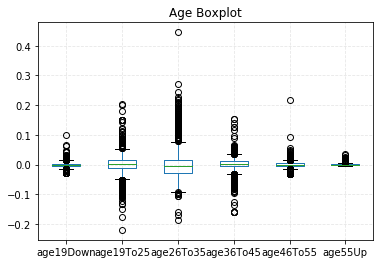

In [47]:
dt1.plot.box(title="Age Boxplot") 
plt.grid(linestyle="--", alpha=0.3)
plt.show()

从上面的箱线图可以看出，46to55与age55up分布相近，19down与26To35分布相近，19~25与36~45分布相近，26~35的方差比较大。和之前做过的聚类结果不谋而合。

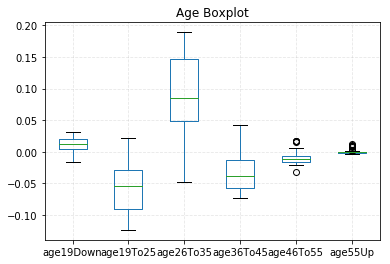

In [48]:
dt1[dt["hwaWeiC2"]=="儿童教育"].plot.box(title="Age Boxplot") 
plt.grid(linestyle="--", alpha=0.3)
plt.show()

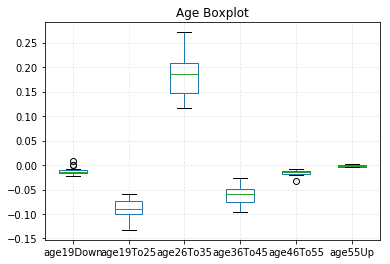

In [49]:
dt1[dt["hwaWeiC2"]=="母婴"].plot.box(title="Age Boxplot") 
plt.grid(linestyle="--", alpha=0.3)
plt.show()

母婴类26~35明显较多。

下面看看“医疗”，“婚恋”，“办公软件”有没有特点。

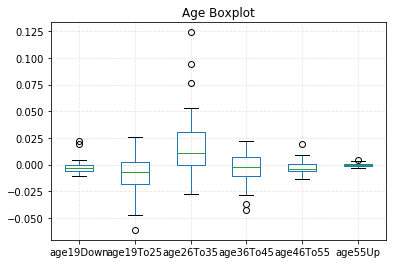

In [50]:
dt1[dt["hwaWeiC2"]=="医疗"].plot.box(title="Age Boxplot") 
plt.grid(linestyle="--", alpha=0.3)
plt.show()

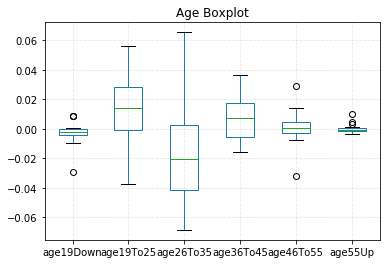

In [51]:
dt1[dt["hwaWeiC2"]=="婚恋"].plot.box(title="Age Boxplot") 
plt.grid(linestyle="--", alpha=0.3)
plt.show()

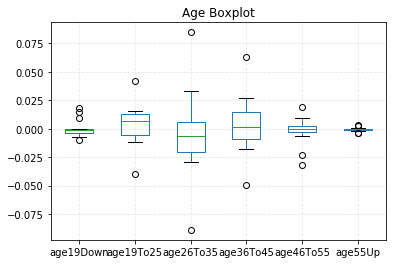

In [52]:
dt1[dt["hwaWeiC2"]=="办公软件"].plot.box(title="Age Boxplot") 
plt.grid(linestyle="--", alpha=0.3)
plt.show()

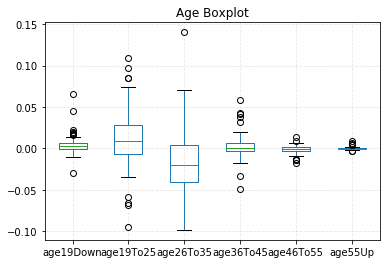

In [53]:
dt1[dt["hwaWeiC2"]=="学习"].plot.box(title="Age Boxplot") 
plt.grid(linestyle="--", alpha=0.3)
plt.show()

学习类的19~25更多些。

值得注意的是，虽然“备考”类会比其他app更年轻化些（从下图可以看出），但是仍然是26~35的人数最多，也就是仍然最有可能被26~35的用户使用（从下下图可以看出）。

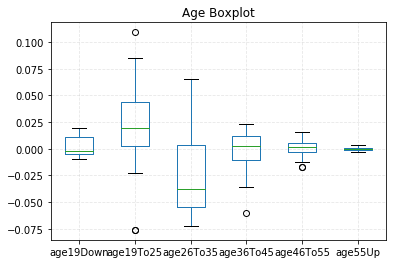

In [54]:
dt1[dt["hwaWeiC2"]=="备考"].plot.box(title="Age Boxplot") 
plt.grid(linestyle="--", alpha=0.3)
plt.show()

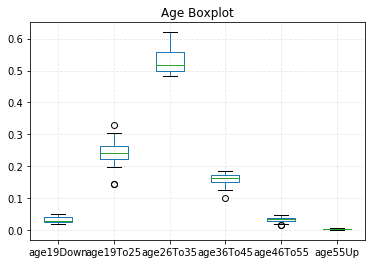

In [55]:
dt[dt["hwaWeiC2"]=="备考"].iloc[:,2:8].plot.box(title="Age Boxplot") 
plt.grid(linestyle="--", alpha=0.3)
plt.show()

下面可以看看可不可以从19~25阶段异常（比95%分位数多和比5%分位数少的）的应用介绍中提取些关键词。

In [56]:
import jieba
import jieba.analyse

In [57]:
#19~25阶段
dt19To25High=dt.loc[(dt1["age19To25"]>np.percentile(dt1["age19To25"],95))][["age19To25","appName","intro"]].drop_duplicates()
contentDt19To25High= ("".join(i for i in dt19To25High['intro']))
jieba.analyse.extract_tags(contentDt19To25High, topK=30, withWeight=True)

[('考研', 0.10411829871585392),
 ('证件照', 0.06934021967310419),
 ('考试', 0.05030886943583459),
 ('英语', 0.05021481038379699),
 ('APP', 0.04622681311540279),
 ('教师', 0.03708948819954458),
 ('美食', 0.03517504166064876),
 ('真题', 0.034670109836552096),
 ('学习', 0.03288800755061547),
 ('微信', 0.03081787541026853),
 ('com', 0.03081787541026853),
 ('功能', 0.029601355965950593),
 ('用户', 0.027846269683346934),
 ('单词', 0.026734774808909775),
 ('一款', 0.025513742624612246),
 ('体验', 0.024749983534046185),
 ('微博', 0.02439748469979592),
 ('四六级', 0.02439748469979592),
 ('课程', 0.023400372687070892),
 ('在线', 0.023211078644165415),
 ('训练', 0.0228548491294522),
 ('返利', 0.02239636571213749),
 ('服务', 0.022378504112323307),
 ('一键', 0.022359670760816328),
 ('海量', 0.022315814586631583),
 ('普通话', 0.021783890585037595),
 ('会计', 0.021714680773764768),
 ('提供', 0.021634664457525238),
 ('免费', 0.021570072297413534),
 ('直播', 0.02053733933769925)]

In [58]:
dt19To25Low=dt.loc[(dt1["age19To25"]<np.percentile(dt1["age19To25"],5))][["age19To25","appName","intro"]].drop_duplicates()
contentDt19To25Low= ("".join(i for i in dt19To25Low['intro']))
jieba.analyse.extract_tags(contentDt19To25Low, topK=30, withWeight=True)

[('宝宝', 0.3658310027698678),
 ('巴士', 0.250443602874056),
 ('儿歌', 0.1585364471758785),
 ('早教', 0.11558553129088743),
 ('启蒙', 0.09041500047502085),
 ('育儿', 0.08716307495342465),
 ('儿童', 0.0753743815882835),
 ('故事', 0.05978209818388803),
 ('认知', 0.05653017077539071),
 ('学习', 0.05264439142270578),
 ('益智', 0.049623617779261456),
 ('APP', 0.04770514727184633),
 ('培养', 0.04424735253751042),
 ('内容', 0.041282207005095294),
 ('互动', 0.04057036793288327),
 ('英文', 0.03948567705376653),
 ('动画', 0.03779263157215605),
 ('妈妈', 0.03748124061404169),
 ('孕期', 0.03741734427279452),
 ('音乐', 0.03711667043995593),
 ('美食', 0.036841730154396665),
 ('成长', 0.03670002130450804),
 ('绘本', 0.036312873296480044),
 ('童谣', 0.03621962462237046),
 ('专注', 0.035974092206339486),
 ('童话故事', 0.035782823085676),
 ('角色扮演', 0.034939958388278736),
 ('百科', 0.03450217140684336),
 ('爸爸妈妈', 0.034198728928016675),
 ('知识', 0.03303165966222156)]

In [70]:
def findOlder(mydf):
    concat=str(mydf["appName"])+str(mydf["intro"])
    olderpt=re.compile(r'老人|老年')
    if len(olderpt.findall(concat))>1:
        return 1
    else:
        return 0

In [71]:
huaWei["old"]=huaWei.apply(lambda x: findOlder(x),axis=1)

In [72]:
huaWei[huaWei["old"]==1]

,appName,hwaWeiC1,hwaWeiC2,intro,label,package,bank,old
712,如意老人桌面,主题个性,桌面,如意桌面 更懂父母。带视频教程的老人桌面。\n左屏新增如意父母帮模块，开启父母的网络新生活！...,"主题个性,桌面,电话,短信,天气",com.yaoo.qlauncher,None,1
1093,简易老人桌面,主题个性,桌面,简易老人桌面是一款专为老人打造的简单而实用的应用桌面APP。\r\n功能简介：\r\n【无需...,"主题个性,桌面",com.android.launcher5.oldlauncher,None,1
1140,微关爱手机定位防护,出行导航,导航,微关爱是一款家人之间使用的手机定位软件，实时视频监控他/她所处环境及现状，定位他/她的位置，...,"出行导航,导航",com.unking.weiguanai,None,1
2121,戏曲多多,影音娱乐,视频,戏曲多多——戏曲评书大全、京剧相声小说二人转、经典老电影、热门广场舞……是陪伴休闲时光的好选...,"影音娱乐,视频",com.duoduo.opera,None,1
2392,银美老人桌面,主题个性,桌面,银美老人桌面是基于安卓系统开发的老人桌面，是符合50 +人群使用习惯与特点的老人桌面，简单、...,"主题个性,桌面",com.jugochina.blch,None,1
3107,怕怕,出行导航,导航,怕怕——款领先的查找朋友定位追踪防身软件，7*24小时守护你的人身安全~~ \n面试找工作、...,"出行导航,导航",com.zhongan.papa,None,1
3251,手机定位防走丢,出行导航,导航,一款非常好用的关爱定位APP，专注于“个人及家庭”定位关爱守护的应用，实时定位家庭老人、小孩...,"出行导航,导航,定位",com.xcloudtech.locate,None,1
3883,找帮手机定位防盗,出行导航,导航,手机防盗，找回手机，定位孩子，保护老人，维护夫妻和谐等（需知情使用）请认准“找帮”，纯净免费...,"出行导航,导航",com.jlzb.android,None,1
4011,广场舞教学视频,运动健康,运动,舞蹈学习的好助手，让广大中老年朋友提供广场舞学习助手。是一款专为广场舞爱好者量身打造的广场舞...,"运动健康,运动",gcws.miai.haao,None,1
4438,思归,运动健康,运动,远方的游子思念亲人，家中的妻子盼望丈夫归来。思归，拉近您与家人的距离。思归是一款可以记录并查...,"运动健康,运动",com.missyouback,None,1


In [74]:
huaWei[huaWei["old"]==1].to_excel('./old.xlsx')

用匹配的方式可以匹配出一些介绍里含有老人、老年的应用。